In [1]:
import os
import xarray as xr
import xesmf as xe
import numpy as np
from statistics import NormalDist
import statsmodels.api as smapi
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style='ticks',font_scale=2)

In [2]:
def ols(x,y,deg=1):
    if np.isnan(x).all() or np.isnan(y).all():
        return np.nan, np.nan

    isna = np.logical_or(np.isnan(x),np.isnan(y))
    x = x[~isna]
    y = y[~isna]
    if (len(x)<20 or len(y)<20):
        return np.nan, np.nan
    if (y==y.max()).all() or (x==x.max()).all():
        return np.nan,np.nan
    mod = smapi.OLS(y,smapi.add_constant(x)).fit()
    return mod.params[1], mod.pvalues[1]

def mod_r2(x,y,deg=1):
    if np.isnan(x).all() or np.isnan(y).all():
        return np.nan
    isna = np.logical_or(np.isnan(x),np.isnan(y))
    x = x[~isna]
    y = y[~isna]
    if (len(x)<20 or len(y)<20):
        return np.nan
    if (y==y.max()).all() or (x==x.max()).all():
        return np.nan,np.nan
    mod = smapi.OLS(y,smapi.add_constant(x)).fit()
    return mod.rsquared

In [3]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'agottlieb','snow_nonlinearity')
data_dir = os.path.join(project_dir,'data','processed')

In [4]:
ims_ds = xr.open_dataset(os.path.join(data_dir,'ims_24km','wy_sc.nc')).sel(time=slice("1998","2022"))
era5_ds = xr.open_dataset(os.path.join(data_dir,'era5','ndjfm_stats.nc')).sel(time=slice("1998","2022"))
ims_ds['sc'] = ims_ds['sc'].clip(max=365)
ims_ds['sc_frac'] = ims_ds['sc']/365
ims_ds['sc_anom'] = ims_ds['sc']-ims_ds['sc'].mean("time")
era5_ds['cold_days'] = 151-era5_ds['warm_days'].clip(max=151)
era5_warm = xr.open_dataset(os.path.join(project_dir,'data','interim','era5_tmean_stats','warm_std_all.nc'))

sc_mask = (ims_ds['sc'].median("time")>30)&(ims_ds['sc'].median("time")<364) # keep placs with snow cover in >3/4 years
ims_ds = ims_ds.where(sc_mask)
era5_ds = era5_ds.where(sc_mask)
era5_warm = era5_warm.where(sc_mask)
era5_ds['tavg_clim'] = era5_ds['tavg'].mean("time")
era5_ds['std_clim'] = era5_ds['tavg_std'].mean("time")
era5_ds['tavg_anom'] = era5_ds['tavg']-era5_ds['tavg'].mean("time")
era5_ds['cold_days_anom'] = era5_ds['cold_days']-era5_ds['cold_days'].mean("time")
era5_ds['rank'] = era5_ds['tavg'].rank("time")

ims_ds['sc_anom'] = ims_ds['sc']-ims_ds['sc'].mean("time")

gridded_dsc_dt, gridded_dsc_dt_p = xr.apply_ufunc(ols,
                                                era5_ds['tavg'],
                                                ims_ds['sc'],
                                                input_core_dims=[['time'],['time']],
                                                output_core_dims=[[],[]],
                                                vectorize=True)
gridded_dsc_dt = 100*gridded_dsc_dt/ims_ds['sc'].mean("time")
gridded_dsc_dt.name = 'dsc_dt'
gridded_dsc_dt_p.name = 'dsc_dt_p'

In [5]:
gridded_r2 = xr.apply_ufunc(mod_r2,
                            era5_ndjfm['tavg'],
                            ims_ndjfm['sc'],
                            input_core_dims=[['time'],['time']],
                            vectorize=True)
gridded_r2.name = 'r2'

In [6]:
gridded_r2_df = xr.merge([gridded_r2,gridded_dsc_dt,era5_ds['tavg'].mean("time")]).to_dataframe().dropna()
gridded_r2_means = []
gridded_r2_stds= []
gridded_sc_means = []
for t in np.arange(-37,6):
    _df = gridded_r2_df[(gridded_r2_df['tavg']>t-2.5)&(gridded_r2_df['tavg']<t+2.5)]
    gridded_r2_means.append(_df['r2'].mean())
    gridded_r2_stds.append(_df['r2'].std())
    gridded_sc_means.append(_df['dsc_dt'].mean())
gridded_r2_means = np.array(gridded_r2_means)
gridded_r2_stds = np.array(gridded_r2_stds)
gridded_sc_means = np.array(gridded_sc_means)

In [7]:
snotel_ds = xr.open_dataset(os.path.join(data_dir,'snotel','ndjfm_stats.nc'))
ecad_ds = xr.open_dataset(os.path.join(data_dir,'ecad','ndjfm_stats.nc'))
ghcnd_ds = xr.open_dataset(os.path.join(data_dir,'ghcnd','ndjfm_stats.nc'))
insitu_ds = xr.concat([snotel_ds,ecad_ds,ghcnd_ds],dim='site').sel(time=slice("1998","2022"))
insitu_ds = insitu_ds.where(insitu_ds['wy_sc'].median("time")>30,drop=True)
insitu_ds = insitu_ds.where((insitu_ds['wy_sc'].count("time")>=20)&(insitu_ds['tavg'].count("time")>=20),drop=True)
insitu_ds['cold_frac']=1-insitu_ds['warm_days_tavg']/151
insitu_ds['wy_sc'] = insitu_ds['wy_sc'].clip(max=365)
insitu_ds['sc_frac'] = insitu_ds['wy_sc']/365
insitu_ds['snow_frac'] = insitu_ds['snow'].sum("time")/(insitu_ds['rain'].sum('time')+insitu_ds['snow'].sum("time"))
insitu_ds['snow_frac_yr'] = insitu_ds['snow']/(insitu_ds['rain']+insitu_ds['snow'])
insitu_ds['melt_frac'] = 1-(np.abs(insitu_ds['total_melt_prepeak'])/insitu_ds['total_accum_prepeak'])
insitu_ds['ppt'] = insitu_ds['rain']+insitu_ds['snow']

In [8]:
insitu_df = insitu_ndjfm[['tavg','ppt','sc','peak_swe',]].to_dataframe()
clim_df = insitu_ndjfm[['tavg','ppt','sc','peak_swe']].mean("time").to_dataframe()


In [46]:
insitu_r2 = xr.apply_ufunc(mod_r2,
                            insitu_ndjfm['tavg'],
                            insitu_ndjfm['sc'],
                            input_core_dims=[['time'],['time']],
                            vectorize=True)
insitu_r2.name = 'r2'

In [47]:
insitu_r2 = clim_df[['tavg']].merge(insitu_r2.to_dataframe(),left_index=True,right_index=True)

In [50]:
insitu_r2_means = []
insitu_r2_stds= []
for t in np.arange(-37,6):
    _df = insitu_r2[(insitu_r2['tavg']>t-2.5)&(insitu_r2['tavg']<t+2.5)]
    insitu_r2_means.append(_df['r2'].mean())
    insitu_r2_stds.append(_df['r2'].std())
insitu_r2_means = np.array(insitu_r2_means)
insitu_r2_stds = np.array(insitu_r2_stds)


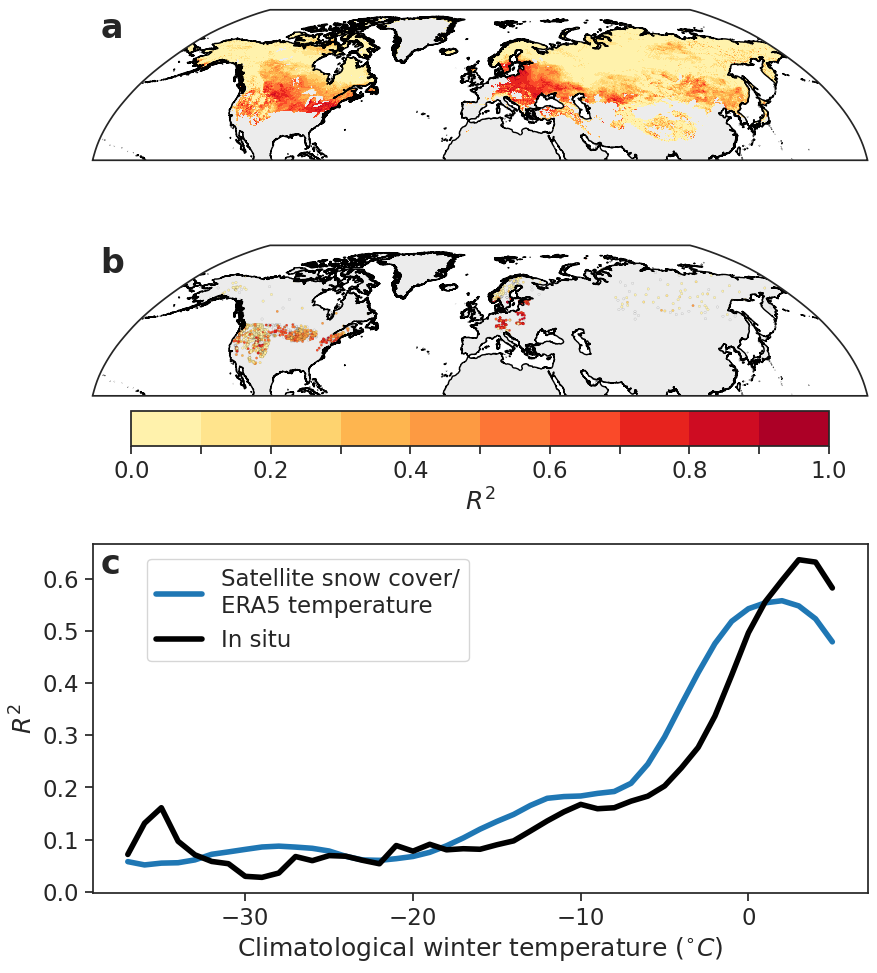

In [56]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs

levels = np.linspace(0,1,11)
cols = sns.color_palette('YlOrRd',len(levels)-1)
cmap = mpl.colors.ListedColormap(cols)
norm = plt.Normalize(vmin=0,vmax=1)
fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(nrows=3,ncols=1,height_ratios=[1,1,1.5],figure=fig)
ax1 = plt.subplot(gs[0],projection=ccrs.Robinson())
ax2 = plt.subplot(gs[1],projection=ccrs.Robinson())
ax3 = plt.subplot(gs[2])
gridded_r2.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,add_colorbar=False)

insitu_r2.plot.scatter(ax=ax2,x='lon',y='lat',c='r2',cmap=cmap,norm=norm,transform=ccrs.PlateCarree(),s=3,edgecolor='black',lw=0.05,colorbar=False)
ax3.plot(ts,gridded_r2_means,label='Satellite snow cover/\nERA5 temperature',color='tab:blue',lw=4)
ax3.plot(ts,insitu_r2_means,label='In situ',color='black',lw=4)
ax3.set_xlabel("Climatological winter temperature ($^{\circ}C$)")
ax3.set_ylabel("$R^2$")
ax3.legend(bbox_to_anchor=(0.5,0.99))

for ax in [ax1,ax2]:
    ax.coastlines("10m")
    ax.set_extent([-180,180,20,90],ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,color='grey',alpha=0.15)

sm = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm,ax=[ax1,ax2],orientation='horizontal',drawedges=False,ticks=levels,pad=0.03,shrink=0.9)
cbar.ax.set_xlabel(r"$R^2$")
for l in cbar.ax.get_xticklabels()[1::2]:
    l.set_visible(False)

labels = ['a','b','c']
for i,ax in enumerate([ax1,ax2,ax3]):
    ax.text(0.01,0.99,labels[i],ha='left',va='top',fontweight='bold',fontsize=24,transform=ax.transAxes)

plt.savefig(os.path.join(project_dir,'reports','figures','r1','supp_mat','png','rsquared.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'reports','figures','r1','supp_mat','pdf','rsquared.pdf'),bbox_inches='tight',dpi=350)

In [9]:
sw = xr.open_dataset(os.path.join(root_dir,'Data','Observations','CERES','CERES_EBAF_Ed4.2_SWin_200003-202407.nc')).sel(time=slice("2000-10-01","2023-09-30"))
sw_ndjfm = sw.where((sw['time.month']>=11)|(sw['time.month']<=3)).resample(time='AS-OCT').mean()

In [10]:
regridder = xe.Regridder(sw_ndjfm,ims_ndjfm,'nearest_s2d')
sw_regrid = regridder(sw_ndjfm)

In [11]:
gpcc_dir = os.path.join(root_dir,'Data','Observations','GPCC','v2022_monthly')
gpcc_files = [os.path.join(gpcc_dir,f) for f in os.listdir(gpcc_dir)]
gpcc_files.sort()


ppt = xr.open_mfdataset(gpcc_files,preprocess=lambda ds: ds['precip'].sel(lat=slice(90,0)).sortby("lat")).sel(time=slice("1998-11-01","2020-09-30"))
ppt_ndjfm = ppt.where((ppt['time.month']>=11)|(ppt['time.month']<=3)).resample(time='AS-OCT').sum(min_count=1)
ppt_ndjfm = ppt_ndjfm.load()
ppt_ndjfm['lat'] = ims_ds['lat']
ppt_ndjfm['lon'] = ims_ds['lon']

In [12]:
def multiple_regression(*args):
    y = args[0]
    if np.isnan(y).sum()==len(y):
        return np.repeat(np.nan,len(args))
    else:
        isna = np.logical_or(np.isnan(y),np.isnan(args[1]))
        if len(args)>2:
            for i in range(2,len(args)):
                isna = np.logical_or(isna,np.isnan(args[i]))
        y = y[~isna]
        X = [x[~isna] for x in args[1:]]
    try:
        X = np.concatenate([x.reshape(-1,1) for x in X], axis=1)
        X = np.concatenate([np.ones(len(y)).reshape(-1,1),X],axis=1)
        
        mod = smapi.OLS(y,X).fit()
        return mod.params
    except:
        return np.repeat(np.nan,len(args))

In [88]:
coef_t_only = xr.apply_ufunc(multiple_regression,
                    ims_ndjfm['sc'].sel(time=slice("2000","2019")),
                      era5_ndjfm['tavg'].sel(time=slice("2000","2019")),
                    input_core_dims=[['time'],['time'],],
                    output_core_dims=[['beta']],
                    vectorize=True)
coef_t_only = 100*coef_t_only/ims_ndjfm['sc'].sel(time=slice("2000","2019")).mean("time")

# Include precip
coef_t_p = xr.apply_ufunc(multiple_regression,
                    ims_ndjfm['sc'].sel(time=slice("2000","2019")),
                      era5_ndjfm['tavg'].sel(time=slice("2000","2019")),
                    ppt_ndjfm['precip'].sel(time=slice("2000","2019")),
                    input_core_dims=[['time'],['time'],['time']],
                    output_core_dims=[['beta']],
                    vectorize=True)
coef_t_p = 100*coef_t_p/ims_ndjfm['sc'].sel(time=slice("2000","2019")).mean("time")

# Include SWin
coef_t_sw = xr.apply_ufunc(multiple_regression,
                    ims_ndjfm['sc'].sel(time=slice("2000","2019")),
                    era5_ndjfm['tavg'].sel(time=slice("2000","2019")),
                    sw_regrid['sfc_sw_down_all_mon'].sel(time=slice("2000","2019")),
                    input_core_dims=[['time'],['time'],['time']],
                    output_core_dims=[['beta']],
                    vectorize=True)
coef_t_sw = 100*coef_t_sw/ims_ndjfm['sc'].sel(time=slice("2000","2019")).mean("time")

# Include P and SWin
coef_t_p_sw = xr.apply_ufunc(multiple_regression,
                    ims_ndjfm['sc'].sel(time=slice("2000","2019")),
                    era5_ndjfm['tavg'].sel(time=slice("2000","2019")),
                    ppt_ndjfm['precip'].sel(time=slice("2000","2019")),
                    sw_regrid['sfc_sw_down_all_mon'].sel(time=slice("2000","2019")),
                    input_core_dims=[['time'],['time'],['time'],['time']],
                    output_core_dims=[['beta']],
                    vectorize=True)
coef_t_p_sw = 100*coef_t_p_sw/ims_ndjfm['sc'].sel(time=slice("2000","2019")).mean("time")

In [94]:
coef_t_only_flat = coef_t_only.isel(beta=1).values.flatten()
coef_t_p_flat = coef_t_p.isel(beta=1).values.flatten()
isna = np.logical_or(np.isnan(coef_t_only_flat),np.isnan(coef_t_p_flat))
coef_t_only_flat = coef_t_only_flat[~isna]
coef_t_p_flat = coef_t_p_flat[~isna]

coef_t_only_flat = coef_t_only.isel(beta=1).values.flatten()
coef_t_sw_flat = coef_t_sw.isel(beta=1).values.flatten()
isna = np.logical_or(np.isnan(coef_t_only_flat),np.isnan(coef_t_sw_flat))
coef_t_only_flat = coef_t_only_flat[~isna]
coef_t_sw_flat = coef_t_sw_flat[~isna]

coef_t_only_flat = coef_t_only.isel(beta=1).values.flatten()
coef_t_p_sw_flat = coef_t_p_sw.isel(beta=1).values.flatten()
isna = np.logical_or(np.isnan(coef_t_only_flat),np.isnan(coef_t_p_sw_flat))
coef_t_only_flat = coef_t_only_flat[~isna]
coef_t_p_sw_flat = coef_t_p_sw_flat[~isna]


In [95]:
p_r = pearsonr(coef_t_p_flat,coef_t_only_flat)
sw_r = pearsonr(coef_t_sw_flat,coef_t_only_flat)
p_sw_r = pearsonr(coef_t_p_sw_flat,coef_t_only_flat)

In [96]:
coef_p_diff = coef_t_only.isel(beta=1)-coef_t_p.isel(beta=1)
coef_sw_diff = coef_t_only.isel(beta=1)-coef_t_sw.isel(beta=1)
coef_p_sw_diff = coef_t_only.isel(beta=1)-coef_t_p_sw.isel(beta=1)


In [289]:
t_only_means = []
t_p_means = []
t_sw_means = []
t_p_sw_means = []
for t in np.arange(-37,6):
    ind = xr.where((era5_ndjfm['tavg_clim']>t-2.5)&(era5_ndjfm['tavg_clim']<t+2.5),True,False)
    t_only_means.append(coef_t_only.isel(beta=1).where(ind).mean())
    t_p_means.append(coef_t_p_sw.isel(beta=1).where(ind).mean())
    t_sw_means.append(coef_t_sw.isel(beta=1).where(ind).mean())
    t_p_sw_means.append(coef_t_p_sw.isel(beta=1).where(ind).mean())
    
t_only_means = np.array(t_only_means)
t_p_means = np.array(t_p_means)
t_sw_means = np.array(t_sw_means)
t_p_sw_means = np.array(t_p_sw_means)

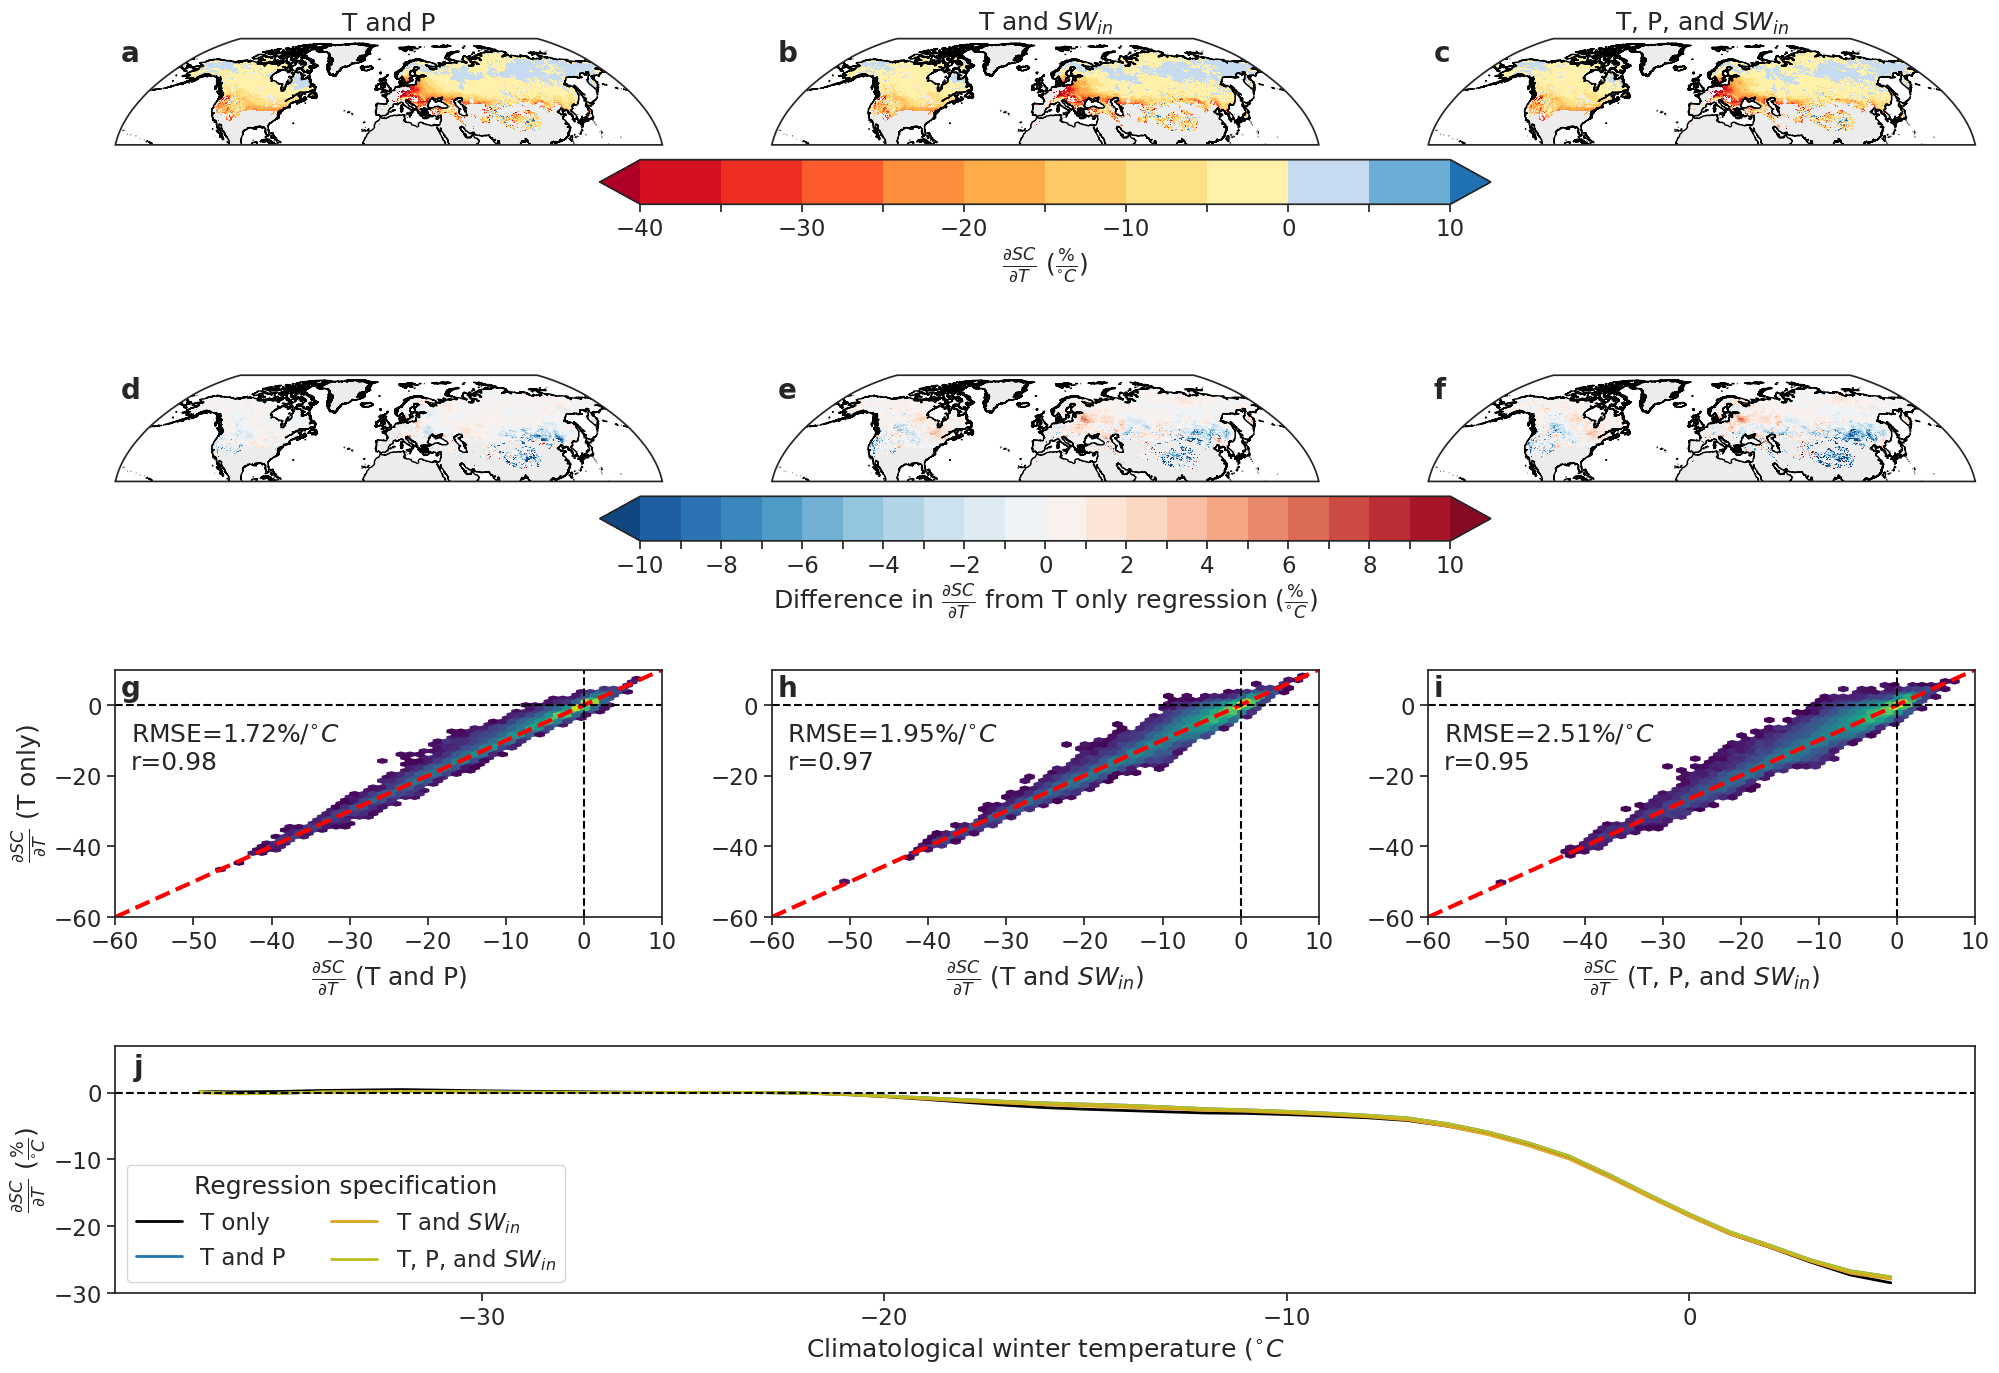

In [291]:
sns.set(style='ticks',font_scale=1.5)
cols = np.concatenate([sns.color_palette("YlOrRd_r",9),sns.color_palette("Blues",3)])
cmap= mpl.colors.ListedColormap(cols[1:-1])
cmap.set_under(cols[0])
cmap.set_over(cols[-1])
norm = plt.Normalize(vmin=-40,vmax=10)

diff_levels = np.linspace(-10,10,21)
diff_cols = sns.color_palette("RdBu_r",len(diff_levels)+1)
diff_cmap = mpl.colors.ListedColormap(diff_cols[1:-1])
diff_cmap.set_under(diff_cols[0])
diff_cmap.set_over(diff_cols[-1])
diff_norm = plt.Normalize(vmin=-10,vmax=10)

fig = plt.figure(figsize=(24,18))
gs = gridspec.GridSpec(nrows=6,ncols=3,height_ratios=[1.2,1.2,0.2,1,0.2,1],figure=fig)

# ax11 = plt.subplot(gs[0,:],projection=ccrs.Robinson())
ax12 = plt.subplot(gs[0,0],projection=ccrs.Robinson())
ax13 = plt.subplot(gs[0,1],projection=ccrs.Robinson())
ax14 = plt.subplot(gs[0,2],projection=ccrs.Robinson())

ax22 = plt.subplot(gs[1,0],projection=ccrs.Robinson())
ax23 = plt.subplot(gs[1,1],projection=ccrs.Robinson())
ax20 = plt.subplot(gs[1,2],projection=ccrs.Robinson())

ax32 = plt.subplot(gs[3,0])
ax33 = plt.subplot(gs[3,1])
ax34 = plt.subplot(gs[3,2])

ax4 = plt.subplot(gs[5,:])

## COEFFICIENTS ##
# T only
coef_t_only.isel(beta=1).plot(ax=ax11,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,add_colorbar=False)
ax11.title.set_text("T only")
# ax11.text(-0.1,0.5,"T only",rotation=90,ha='center',va='center',transform=ax11.transAxes)

# T and P
coef_t_p.isel(beta=1).plot(ax=ax12,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,add_colorbar=False)
ax12.title.set_text("T and P")
# ax12.text(-0.1,0.5,"T and P",rotation=90,ha='center',va='center',transform=ax12.transAxes)

# T and SW
coef_t_sw.isel(beta=1).plot(ax=ax13,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,add_colorbar=False)
ax13.title.set_text("T and $SW_{in}$")
# ax13.text(-0.1,0.5,"T and $SW_{in}$",rotation=90,ha='center',va='center',transform=ax13.transAxes)

# T and P and SW
coef_t_p_sw.isel(beta=1).plot(ax=ax14,transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,add_colorbar=False)
ax14.title.set_text("T, P, and $SW_{in}$")
# ax14.text(-0.1,0.5,"T, P, and $SW_{in}$",rotation=90,ha='center',va='center',transform=ax14.transAxes)

sm = plt.cm.ScalarMappable(norm=norm,cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm,
                    ax=[ax12,ax13,ax14],
                    orientation='horizontal',
                    drawedges=False,
                    extend='both',
                    ticks=np.arange(-40,11,5),
                    pad=0.05,
                    shrink=0.7)
cbar.ax.set_xlabel(r'$\frac{\partial SC}{\partial T}$'+r' ($\frac{\%}{^{\circ}C}$)')
for l in cbar.ax.get_xticklabels()[1::2]:
    l.set_visible(False)
    
## DIFFERENCES ##
# T and P diff
coef_p_diff.plot(ax=ax22,transform=ccrs.PlateCarree(),cmap=diff_cmap,norm=diff_norm,add_colorbar=False)
# ax22.title.set_text("a - b")

coef_sw_diff.plot(ax=ax23,transform=ccrs.PlateCarree(),cmap=diff_cmap,norm=diff_norm,add_colorbar=False)
# ax23.title.set_text("a - c")

coef_p_sw_diff.plot(ax=ax20,transform=ccrs.PlateCarree(),cmap=diff_cmap,norm=diff_norm,add_colorbar=False)
# ax20.title.set_text("a - d")

diff_sm = plt.cm.ScalarMappable(norm=diff_norm,cmap=diff_cmap)
diff_sm.set_array([])
diff_cbar = fig.colorbar(diff_sm,
                         ax=[ax22,ax23,ax20],
                         orientation='horizontal',
                         drawedges=False,
                         extend='both',
                         ticks=diff_levels,
                         pad=0.05,
                         shrink=0.7)
diff_cbar.ax.set_xlabel(r'Difference in $\frac{\partial SC}{\partial T}$'+r' from T only regression ($\frac{\%}{^{\circ}C}$)')
for l in diff_cbar.ax.get_xticklabels()[1::2]:
    l.set_visible(False)
## SCATTER ##
# T vs T and P #
ax32.hexbin(coef_t_only_flat,coef_t_p_flat,bins='log',mincnt=10,cmap='viridis')

# T vs T and SW #
ax33.hexbin(coef_t_only_flat,coef_t_sw_flat,bins='log',mincnt=10,cmap='viridis')

# T vs T and P and SW#
ax34.hexbin(coef_t_only_flat,coef_t_p_sw_flat,bins='log',mincnt=10,cmap='viridis')

ax4.plot(ts,t_only_means,color='black',lw=2,label='T only',)
ax4.plot(ts,t_p_means,color='tab:blue',lw=2,label='T and P')
ax4.plot(ts,t_sw_means,color='goldenrod',lw=2,label='T and $SW_{in}$')
ax4.plot(ts,t_p_sw_means,color='tab:olive',lw=2,label='T, P, and $SW_{in}$')
ax4.axhline(color='black',linestyle='--')
ax4.set_xlabel("Climatological winter temperature ($^{\circ}C$")
ax4.set_ylabel(r'$\frac{\partial SC}{\partial T}$'+r' ($\frac{\%}{^{\circ}C}$)',)
ax4.set_ylim(-30,7)
ax4.legend(loc='lower left',title='Regression specification',ncol=2)
map_labels=['a','b','c','d','e','f',]
for i,ax in enumerate([ax12,ax13,ax14,ax22,ax23,ax20]):
    ax.coastlines("10m")
    ax.set_extent([-180,180,20,90],ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND,color='grey',alpha=0.15)
    ax.text(0.01,0.99,map_labels[i],ha='left',va='top',fontweight='bold',fontsize=20,transform=ax.transAxes)
    
scat_labels = ['g','h','i',]
ylabels = [r'$\frac{\partial SC}{\partial T}$ (T and P)',
           r'$\frac{\partial SC}{\partial T}$ (T and $SW_{in}$)',
           r'$\frac{\partial SC}{\partial T}$ (T, P, and $SW_{in}$)']
scat_corrs = [p_r,sw_r,p_sw_r]
rmses = [np.sqrt(np.nansum(np.power(coef_p_diff.values,2))/coef_p_diff.count()).values,
         np.sqrt(np.nansum(np.power(coef_sw_diff.values,2))/coef_sw_diff.count()).values,
         np.sqrt(np.nansum(np.power(coef_p_sw_diff.values,2))/coef_p_sw_diff.count()).values,]
for j,ax in enumerate([ax32,ax33,ax34]):
    ax.set_ylim(-60,10)
    ax.set_xlim(-60,10)
    ax.plot([-60,10],[-60,10],color='red',lw=3,linestyle='--')
    ax.axhline(0,color='black',linestyle='--')
    ax.axvline(0,color='black',linestyle='--')
    if j==0:
        ax.set_ylabel(r"$\frac{\partial SC}{\partial T}$ (T only)")
    # ax.yaxis.set_label_position('right')
    # ax.yaxis.tick_right()
    ax.set_xlabel(ylabels[j])
    
    ax.text(0.01,0.98,scat_labels[j],ha='left',va='top',fontweight='bold',fontsize=20,transform=ax.transAxes)
    ax.text(-58,-5,f'RMSE={np.round(rmses[j],2)}'+r'$\%/^{\circ}C$'+f'\nr={np.round(scat_corrs[j][0],2)}',ha='left',va='top')
ax4.text(0.01,0.97,'j',ha='left',va='top',fontweight='bold',fontsize=20,transform=ax4.transAxes)

plt.savefig(os.path.join(project_dir,'reports','figures','r1','supp_mat','png','additional_regressors.png'),bbox_inches='tight',dpi=350)
plt.savefig(os.path.join(project_dir,'reports','figures','r1','supp_mat','pdf','additional_regressors.pdf'),bbox_inches='tight',dpi=350)


In [93]:
from statsmodels.stats.diagnostic import linear_harvey_collier, linear_rainbow

def check_resids(df,mod_str):
    mod_vars = [mod_str.split("~")[0]]+mod_str.split("~")[1].split("+")
    df = df.dropna(subset=mod_vars)
    if len(df)<2:
        return np.nan
    else:
        mod = smapi.OLS.from_formula(mod_str,data=df).fit()
        try:
            return linear_harvey_collier(mod)[1]
        except:
            return np.nan
        
sc_resid_norm = insitu_df.groupby("site").apply(lambda df: check_resids(df,'sc~tavg'))
sc_resid_norm.name = 'harvey_p'


In [113]:
def harvey_collier(*args):
    y = args[0]
    if np.isnan(y).sum()==len(y):
        return np.nan
    else:
        isna = np.logical_or(np.isnan(y),np.isnan(args[1]))
        if len(args)>2:
            for i in range(2,len(args)):
                isna = np.logical_or(isna,np.isnan(args[i]))
        y = y[~isna]
        X = [x[~isna] for x in args[1:]]
    try:
        X = np.concatenate([x.reshape(-1,1) for x in X], axis=1)
        X = np.concatenate([np.ones(len(y)).reshape(-1,1),X],axis=1)
        
        mod = smapi.OLS(y,X).fit()
        return linear_harvey_collier(mod)[1]
    except:
        return np.nan
    
gridded_resid_norm = xr.apply_ufunc(harvey_collier,
                    ims_ndjfm['sc'],
                    era5_ndjfm['tavg'],
                    input_core_dims=[['time'],['time'],],
                    vectorize=True)
gridded_resid_norm.name = 'harvey_p'